<a href="https://colab.research.google.com/github/thwlruss10/VDA_pipeline/blob/main/TutorialRedoux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### follows Medium code sequence, incuding Regex


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets nltk scikit-learn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is i

In [ ]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import re
import pandas as pd
import os
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

# import nltk
# nltk.download('wordnet')

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#set_caching_enabled(True)>> this line deleted as 'datasets' no longer supports explicit cahce enabling
#set_caching_enabled(True)
logging.set_verbosity_error()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split

# Define base directory pointing to your Drive location
base_dir = "/content/drive/MyDrive/FinalProject/dataset"
os.makedirs(base_dir, exist_ok=True)

# Define regex to extract image ID
image_pattern = re.compile(r"( (in |on |of )?(the |this )?(image\d*) \?)")

# Read the raw Q&A file
qa_file = os.path.join(base_dir, "all_qa_pairs.txt")
with open(qa_file, "r", encoding="utf-8") as f:
    qa_data = [x.strip() for x in f.readlines()]

# Parse and clean questions, answers, and image IDs
records = []
for i in range(0, len(qa_data), 2):
    match = image_pattern.findall(qa_data[i])
    if match:
        img_id = match[0][3]
        question = qa_data[i].replace(match[0][0], "").strip()
        answer = qa_data[i + 1].strip()
        records.append({"question": question, "answer": answer, "image_id": img_id})

# Create DataFrame from parsed data
df = pd.DataFrame(records)

# Create answer space (flatten multiple answers per question if needed)
answer_space = []
for ans in df["answer"].to_list():
    if "," in ans:
        answer_space += ans.replace(" ", "").split(",")
    else:
        answer_space.append(ans)

answer_space = sorted(set(answer_space))

# Write the answer space to file
with open(os.path.join(base_dir, "answer_space.txt"), "w", encoding="utf-8") as f:
    f.writelines("\n".join(answer_space))

# Split dataset into training and evaluation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save to CSV
train_df.to_csv(os.path.join(base_dir, "data_train.csv"), index=False)
test_df.to_csv(os.path.join(base_dir, "data_eval.csv"), index=False)


In [ ]:
'''
# Define regex to extract image ID
image_pattern = re.compile(r"( (in |on |of )?(the |this )?(image\d*) \?)")

with open(os.path.join("dataset", "all_qa_pairs.txt")) as f:
    qa_data = [x.strip() for x in f.readlines()]

records = []

for i in range(0, len(qa_data), 2):
    match = image_pattern.findall(qa_data[i])
    if match:
        img_id = match[0][3]
        question = qa_data[i].replace(match[0][0], "").strip()
        answer = qa_data[i + 1].strip()
        records.append({"question": question, "answer": answer, "image_id": img_id})

# Create DataFrame from list of records
df = pd.DataFrame(records)

# Create answer space (for classification)
answer_space = []
for ans in df.answer.to_list():
    if "," in ans:
        answer_space += ans.replace(" ", "").split(",")
    else:
        answer_space.append(ans)

answer_space = sorted(set(answer_space))

with open(os.path.join("dataset", "answer_space.txt"), "w") as f:
    f.writelines("\n".join(answer_space))

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.to_csv(os.path.join("dataset", "data_train.csv"), index=False)
test_df.to_csv(os.path.join("dataset", "data_eval.csv"), index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/all_qa_pairs.txt'

In [ ]:
for i in range(0, 10, 2):  # look at 5 question/answer pairs
    print(f"Q: {qa_data[i]}")
    print(f"A: {qa_data[i+1]}")
    print("-" * 40)


Q: what is on the left side of the white oven on the floor and on right side of the blue armchair in the image1 ?
A: garbage_bin
----------------------------------------
Q: what is on the left side of the fire extinguisher and on the right side of the chair in the image1 ?
A: table
----------------------------------------
Q: what is between the the two white and black garbage bins in the image1 ?
A: chair
----------------------------------------
Q: how many objects are between the fire extinguisher and the white oven on the floor in the image1 ?
A: 3
----------------------------------------
Q: what is the largest object in this picture in the image1 ?
A: washing_machine
----------------------------------------


In [ ]:
import re

image_pattern = re.compile(r"( (in |on |of )?(the |this )?(image\d*) \?)")

for i in range(0, 10, 2):
    match = image_pattern.findall(qa_data[i])
    print(f"Q: {qa_data[i]}")
    print(f"Match: {match}")
    print("-" * 40)


Q: what is on the left side of the white oven on the floor and on right side of the blue armchair in the image1 ?
Match: [(' in the image1 ?', 'in ', 'the ', 'image1')]
----------------------------------------
Q: what is on the left side of the fire extinguisher and on the right side of the chair in the image1 ?
Match: [(' in the image1 ?', 'in ', 'the ', 'image1')]
----------------------------------------
Q: what is between the the two white and black garbage bins in the image1 ?
Match: [(' in the image1 ?', 'in ', 'the ', 'image1')]
----------------------------------------
Q: how many objects are between the fire extinguisher and the white oven on the floor in the image1 ?
Match: [(' in the image1 ?', 'in ', 'the ', 'image1')]
----------------------------------------
Q: what is the largest object in this picture in the image1 ?
Match: [(' in the image1 ?', 'in ', 'the ', 'image1')]
----------------------------------------


In [ ]:
from datasets import load_dataset
import os

# Set the base directory where your dataset files live in Google Drive
base_dir = "/content/drive/MyDrive/FinalProject/dataset"

# Load the training & evaluation dataset from CSV files
dataset = load_dataset(
    "csv",
    data_files={
        "train": os.path.join(base_dir, "data_train.csv"),
        "test": os.path.join(base_dir, "data_eval.csv")
    }
)

# Load the space of all possible answers
with open(os.path.join(base_dir, "answer_space.txt"), "r", encoding="utf-8") as f:
    answer_space = f.read().splitlines()

# Map answers to classification labels
dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0])
            for ans in examples['answer']
        ]
    },
    batched=True
)


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9974 [00:00<?, ? examples/s]

Map:   0%|          | 0/2494 [00:00<?, ? examples/s]

In [ ]:
'''# Load the training & evaluation dataset present in CSV format
dataset = load_dataset(
    "csv",
    data_files={
        "train": os.path.join("dataset", "data_train.csv"),
        "test": os.path.join("dataset", "data_eval.csv")
    }
)

# Load the space of all possible answers
with open(os.path.join("dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

# Since we model the VQA task as a multiclass classification problem,
# we need to create the labels from the actual answers
dataset = dataset.map(
    lambda examples: {
        'label': [
            # Select the 1st answer if multiple answers are provided for single question
            answer_space.index(ans.replace(" ", "").split(",")[0])
            for ans in examples['answer']
        ]
    },
    batched=True
)'''

FileNotFoundError: Unable to find '/content/dataset/data_train.csv'

Looking for image at: /content/drive/MyDrive/FinalProject/dataset/images/image1347.png


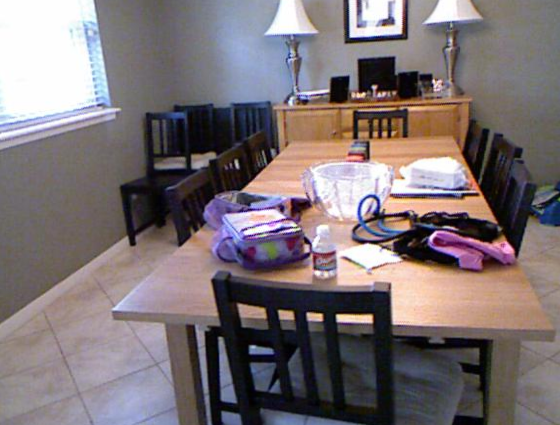

Question:	 what are the things on the table
Answer:		 lamp, photo (Label: 308)


In [ ]:
from IPython.display import display
from PIL import Image
import numpy as np
import os

# Define your image directory (consistent with earlier code)
image_dir = "/content/drive/MyDrive/FinalProject/dataset/images"

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]

    if id is None:
        id = np.random.randint(len(data))

    img_path = os.path.join(image_dir, data[id]["image_id"] + ".png")

    if not os.path.exists(img_path):
        print(f"⚠️ Image not found at: {img_path}")
        return

    print(f"Looking for image at: {os.path.abspath(img_path)}")
    image = Image.open(img_path)
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], f"(Label: {data[id]['label']})")

# Call it
showExample()


In [ ]:

'''
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    img_path = os.path.join("..", "dataset", "images", data[id]["image_id"] + ".png")
    print(f"Looking for image at: {os.path.abspath(img_path)}")
    image = Image.open(os.path.join("..", "dataset", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

showExample()

Looking for image at: /dataset/images/image1236.png


FileNotFoundError: [Errno 2] No such file or directory: '../dataset/images/image1236.png'

### adjust folder structure as required.